# Normality Analysis of Numeric Features

This notebook analyzes the normality of numeric columns in our dataset. For linear models, having normally distributed features can improve model performance. We will:
1. Test for normality using Shapiro-Wilk test (p < 5%)
2. Visualize distributions using Q-Q plots
3. Apply transformations where needed to achieve normality

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

### Load and Prepare Data

In [7]:
DATA_DIR = './Data/'
TRACK_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

RANDOM_STATE = 21
TEST_SIZE = 0.1

In [8]:
tracks_data = pd.read_csv(DATA_DIR + TRACK_FILE)

y = tracks_data['popularity']
X = tracks_data.drop('popularity', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

df = X_train.copy()
df['popularity'] = y_train

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"Analyzing {len(numeric_cols)} numeric columns:")
print(numeric_cols)

Analyzing 15 numeric columns:
Index(['year', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'popularity'],
      dtype='object')


### Helper Functions for Normality Analysis

In [9]:
def plot_distribution_and_qq(data, column, fig_size=(12, 4)):
    """Create distribution plot and Q-Q plot for a given column."""
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, 2, 1)
    
    values = data[column].dropna()
    skew = stats.skew(values)
    
    if abs(skew) > 2: # instrumentallness was hard to see
        sns.histplot(data=data, x=column, kde=True)
        plt.yscale('log')
        plt.title(f'Distribution of {column}\n(log scale, skewness: {skew:.2f})')
    else:
        sns.histplot(data=data, x=column, kde=True)
        plt.title(f'Distribution of {column}\n(skewness: {skew:.2f})')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
    
    plt.tight_layout()
    plt.show()

def test_normality(data, column):
    values = data[column].dropna()
    print(f"\nTesting normality for {column}")
    print(f"Sample size: {len(values)}")
    print(f"Range: {values.min()} to {values.max()}")
    print(f"Mean: {values.mean():.2f}, Std: {values.std():.2f}")
    
    # Shapiro-Wilk test works best with sample size between 3 and 5000
    if len(values) > 5000:
        values = values.sample(5000, random_state=42)
    
    statistic, p_value = shapiro(values)
    print(f"Shapiro test statistic: {statistic:.4f}, p-value: {p_value:.4e}")
    return p_value

def suggest_transformation(data, column, original_p_value):
    values = data[column].dropna()
    
    transformations = {
        'log': lambda x: np.log1p(x - x.min() + 1) if x.min() <= 0 else np.log1p(x),
        'sqrt': lambda x: np.sqrt(x - x.min() + 1) if x.min() <= 0 else np.sqrt(x),
        'box-cox': lambda x: stats.boxcox(x - x.min() + 1)[0] if x.min() <= 0 else stats.boxcox(x)[0],
        'yeo-johnson': lambda x: stats.yeojohnson(x)[0]
    }
    
    results = {'original': original_p_value}
    transformed_data = {}
    
    for name, transform in transformations.items():
        try:
            print(f"\nTrying {name} transformation...")
            transformed = transform(values)
            if np.all(np.isfinite(transformed)):
                p_value = shapiro(transformed)[1]
                print(f"{name} transformation p-value: {p_value:.4e}")
                results[name] = p_value
                transformed_data[name] = transformed
            else:
                print(f"{name} transformation produced invalid values")
        except Exception as e:
            print(f"Error with {name} transformation: {str(e)}")
            continue
    
    best_transform = max(results.items(), key=lambda x: x[1])
    return best_transform, transformed_data.get(best_transform[0])

### Analyze Each Numeric Column


Analyzing year...

Original distribution:


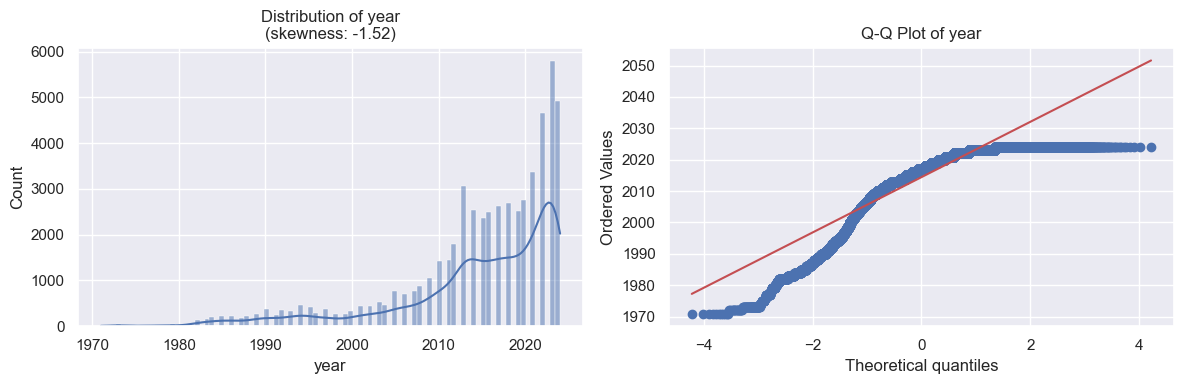


Testing normality for year
Sample size: 56085
Range: 1971 to 2024
Mean: 2014.44, Std: 9.63
Shapiro test statistic: 0.8334, p-value: 3.5026e-58

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 2.0196e-112

Trying sqrt transformation...
sqrt transformation p-value: 2.8035e-112

Trying box-cox transformation...
box-cox transformation p-value: 1.2090e-88

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.2205e-103
Best transformation: original (p-value: 3.5026e-58)

Analyzing acousticness...

Original distribution:


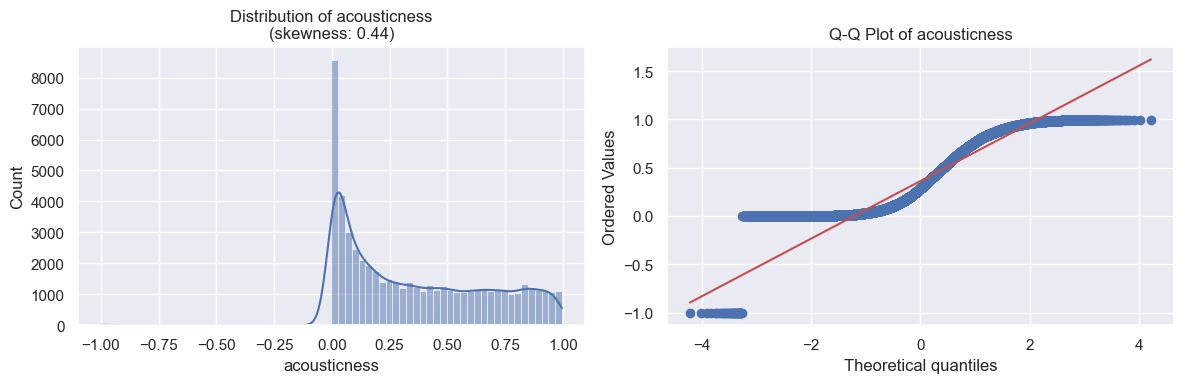


Testing normality for acousticness
Sample size: 56085
Range: -1.0 to 0.996
Mean: 0.36, Std: 0.31
Shapiro test statistic: 0.8965, p-value: 8.4726e-50

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.6155e-98

Trying sqrt transformation...
sqrt transformation p-value: 1.0349e-98

Trying box-cox transformation...
box-cox transformation p-value: 1.2136e-99

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.8284e-99
Best transformation: original (p-value: 8.4726e-50)

Analyzing danceability...

Original distribution:


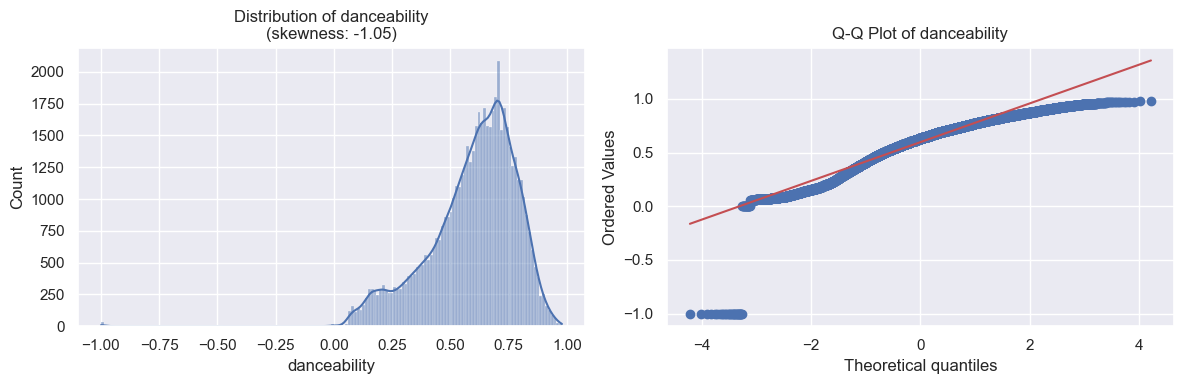


Testing normality for danceability
Sample size: 56085
Range: -1.0 to 0.979
Mean: 0.60, Std: 0.19
Shapiro test statistic: 0.9503, p-value: 3.4868e-38

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 4.7028e-96

Trying sqrt transformation...
sqrt transformation p-value: 1.5818e-93

Trying box-cox transformation...
box-cox transformation p-value: 3.6723e-45

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.9145e-46
Best transformation: original (p-value: 3.4868e-38)

Analyzing duration_ms...

Original distribution:


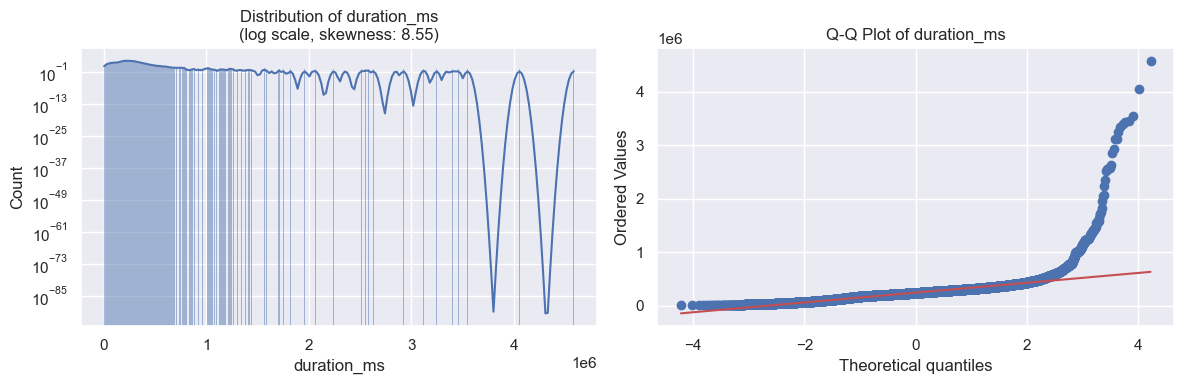


Testing normality for duration_ms
Sample size: 56085
Range: 5000.0 to 4581483.0
Mean: 242236.59, Std: 110397.90
Shapiro test statistic: 0.6318, p-value: 1.1292e-73

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 8.4553e-103

Trying sqrt transformation...
sqrt transformation p-value: 3.6208e-96

Trying box-cox transformation...
box-cox transformation p-value: 6.5463e-93

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 6.5483e-93
Best transformation: original (p-value: 1.1292e-73)

Analyzing energy...

Original distribution:


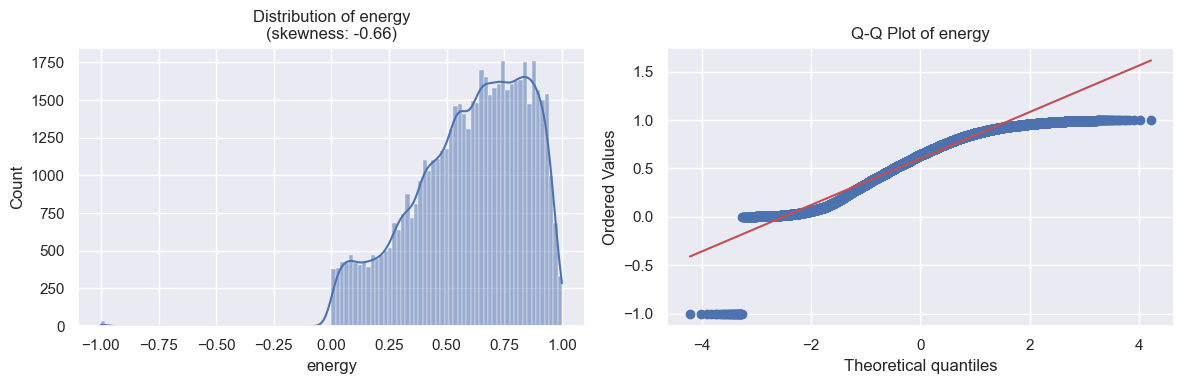


Testing normality for energy
Sample size: 56085
Range: -1.0 to 1.0
Mean: 0.60, Std: 0.25
Shapiro test statistic: 0.9584, p-value: 1.3321e-35

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.6279e-88

Trying sqrt transformation...
sqrt transformation p-value: 2.5330e-86

Trying box-cox transformation...
box-cox transformation p-value: 2.7985e-66

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 5.8353e-67
Best transformation: original (p-value: 1.3321e-35)

Analyzing instrumentalness...

Original distribution:


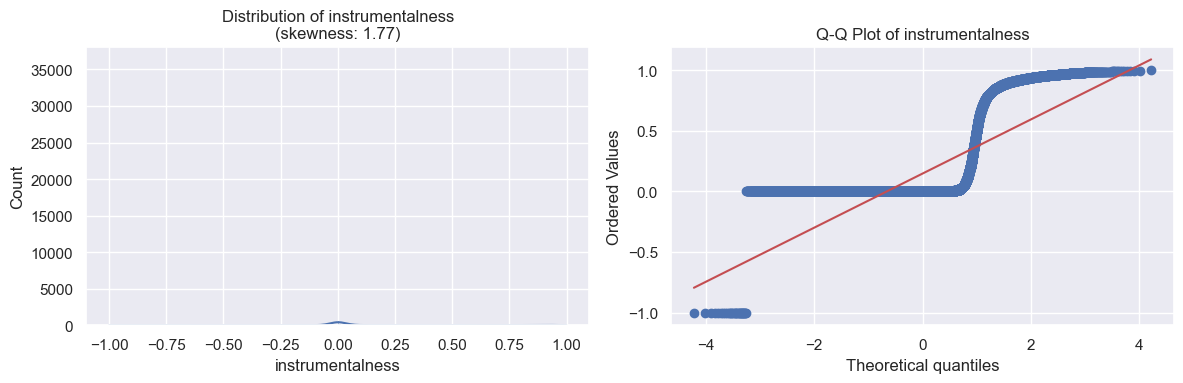


Testing normality for instrumentalness
Sample size: 56085
Range: -1.0 to 0.999
Mean: 0.15, Std: 0.31
Shapiro test statistic: 0.5299, p-value: 8.0219e-79

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.3563e-143

Trying sqrt transformation...
sqrt transformation p-value: 2.9886e-143

Trying box-cox transformation...
box-cox transformation p-value: 1.6746e-145

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.3854e-146
Best transformation: original (p-value: 8.0219e-79)

Analyzing key...

Original distribution:


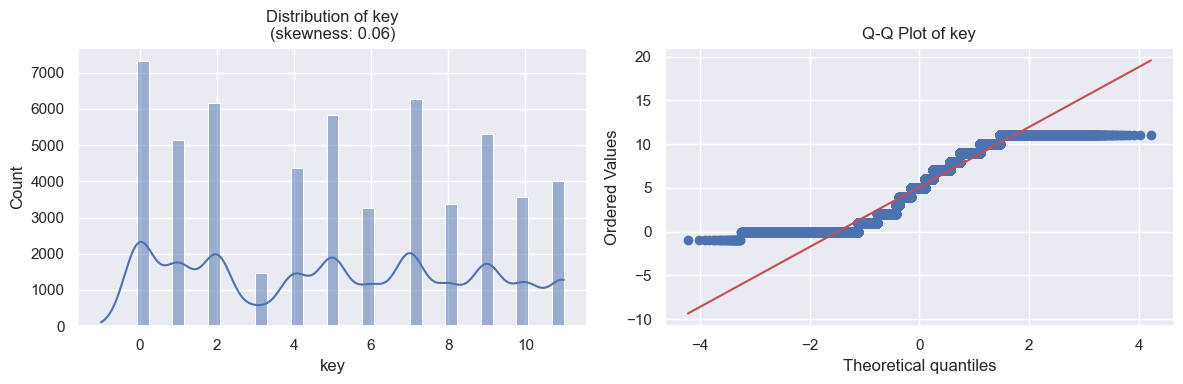


Testing normality for key
Sample size: 56085
Range: -1.0 to 11.0
Mean: 5.10, Std: 3.55
Shapiro test statistic: 0.9329, p-value: 9.9548e-43

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.1350e-98

Trying sqrt transformation...
sqrt transformation p-value: 8.0886e-93

Trying box-cox transformation...
box-cox transformation p-value: 1.2848e-91

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 6.9938e-92
Best transformation: original (p-value: 9.9548e-43)

Analyzing liveness...

Original distribution:


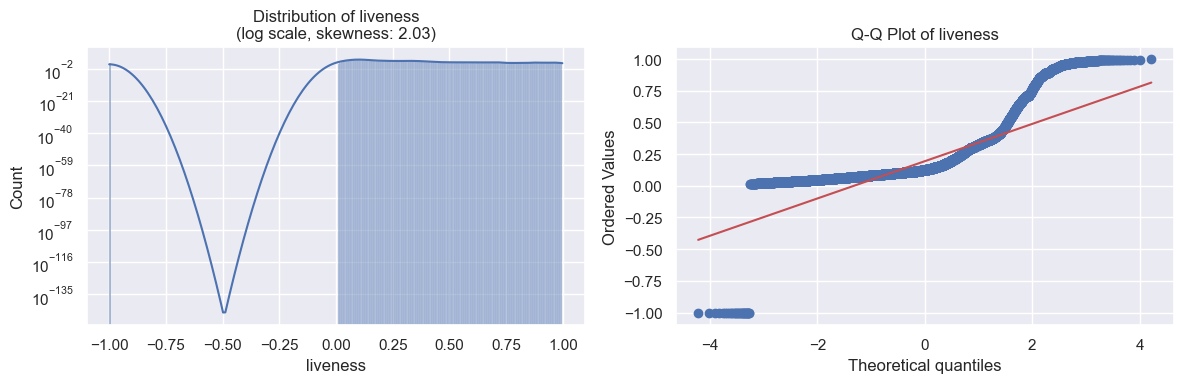


Testing normality for liveness
Sample size: 56085
Range: -1.0 to 0.998
Mean: 0.19, Std: 0.17
Shapiro test statistic: 0.7342, p-value: 4.3771e-67

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.3429e-124

Trying sqrt transformation...
sqrt transformation p-value: 4.0035e-125

Trying box-cox transformation...
box-cox transformation p-value: 7.0365e-126

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.4628e-125
Best transformation: original (p-value: 4.3771e-67)

Analyzing loudness...

Original distribution:


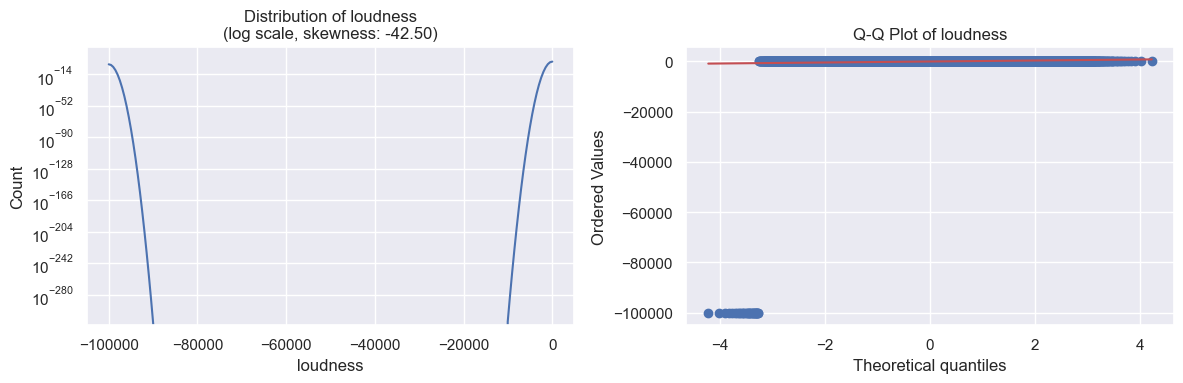


Testing normality for loudness
Sample size: 56085
Range: -100000.0 to 1.233
Mean: -64.22, Std: 2350.19
Shapiro test statistic: 0.0034, p-value: 9.0116e-96

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 4.9380e-167

Trying sqrt transformation...
sqrt transformation p-value: 4.9923e-167

Trying box-cox transformation...
box-cox transformation p-value: 8.4312e-166

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.8844e-63
Best transformation: yeo-johnson (p-value: 1.8844e-63)

Transformed distribution:


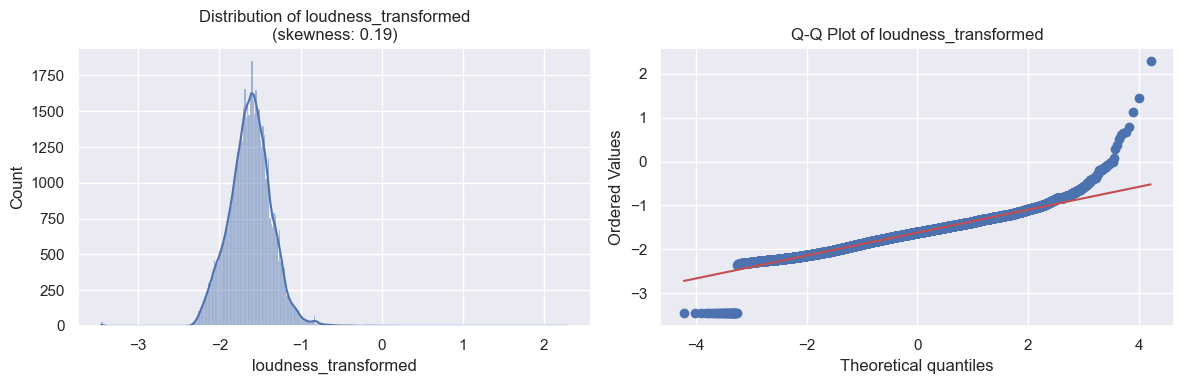


Analyzing mode...

Original distribution:


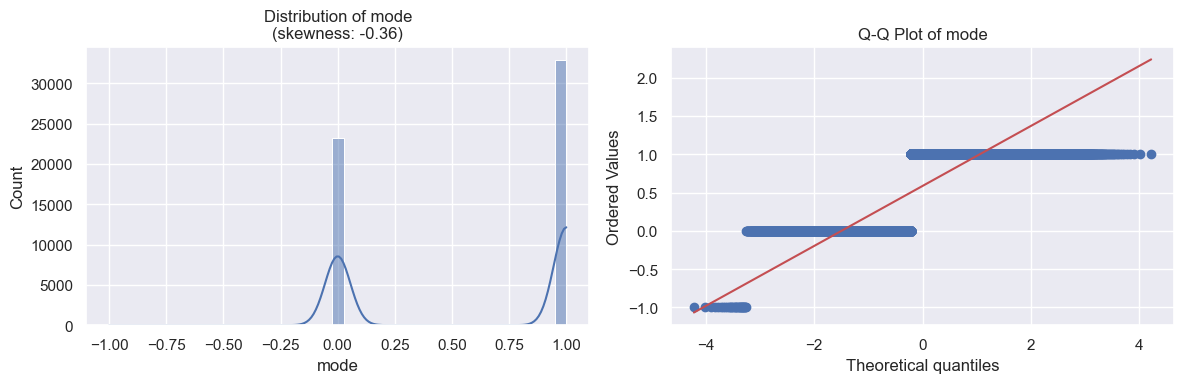


Testing normality for mode
Sample size: 56085
Range: -1.0 to 1.0
Mean: 0.59, Std: 0.49
Shapiro test statistic: 0.6297, p-value: 8.6655e-74

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 6.9448e-136

Trying sqrt transformation...
sqrt transformation p-value: 6.8450e-136

Trying box-cox transformation...
box-cox transformation p-value: 4.8930e-136

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 5.5051e-136
Best transformation: original (p-value: 8.6655e-74)

Analyzing speechiness...

Original distribution:


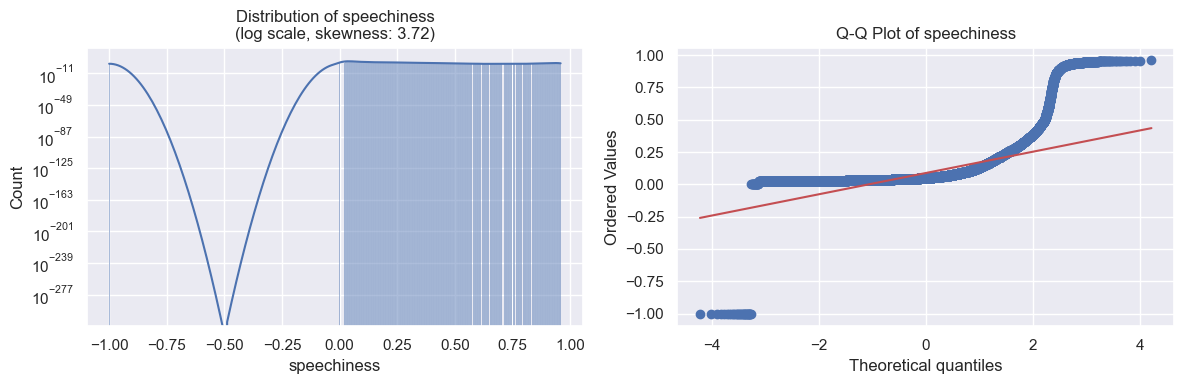


Testing normality for speechiness
Sample size: 56085
Range: -1.0 to 0.959
Mean: 0.09, Std: 0.12
Shapiro test statistic: 0.5275, p-value: 6.2331e-79

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 4.7289e-143

Trying sqrt transformation...
sqrt transformation p-value: 2.3107e-143

Trying box-cox transformation...
box-cox transformation p-value: 1.1281e-143

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.0828e-143
Best transformation: original (p-value: 6.2331e-79)

Analyzing tempo...

Original distribution:


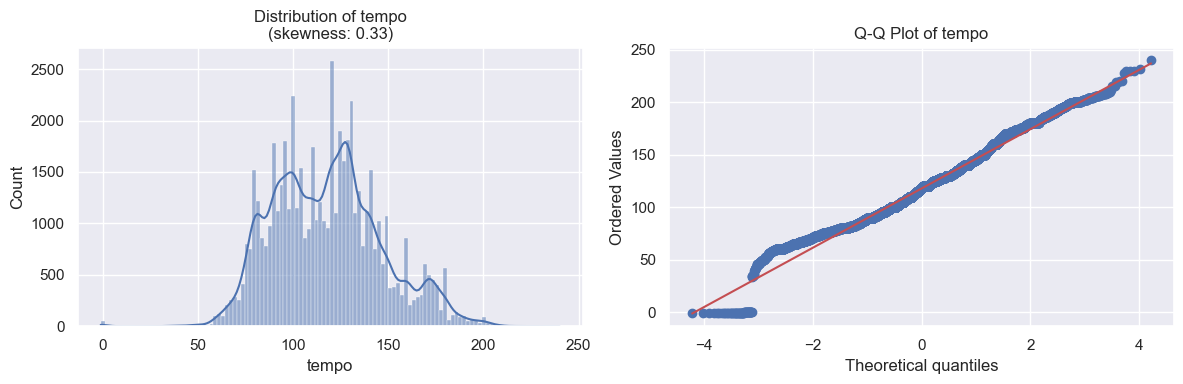


Testing normality for tempo
Sample size: 56085
Range: -1.0 to 239.97
Mean: 117.92, Std: 28.49
Shapiro test statistic: 0.9853, p-value: 2.1993e-22

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.2173e-106

Trying sqrt transformation...
sqrt transformation p-value: 8.8309e-63

Trying box-cox transformation...
box-cox transformation p-value: 8.1598e-54

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 5.2906e-54
Best transformation: original (p-value: 2.1993e-22)

Analyzing time_signature...

Original distribution:


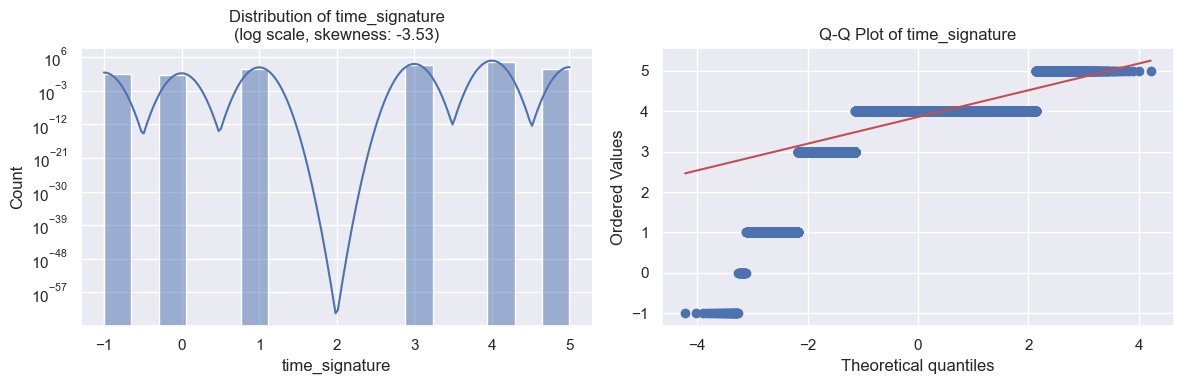


Testing normality for time_signature
Sample size: 56085
Range: -1.0 to 5.0
Mean: 3.86, Std: 0.50
Shapiro test statistic: 0.4480, p-value: 2.6513e-82

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 8.8497e-152

Trying sqrt transformation...
sqrt transformation p-value: 1.2038e-150

Trying box-cox transformation...
box-cox transformation p-value: 1.0966e-146

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.2232e-146
Best transformation: original (p-value: 2.6513e-82)

Analyzing valence...

Original distribution:


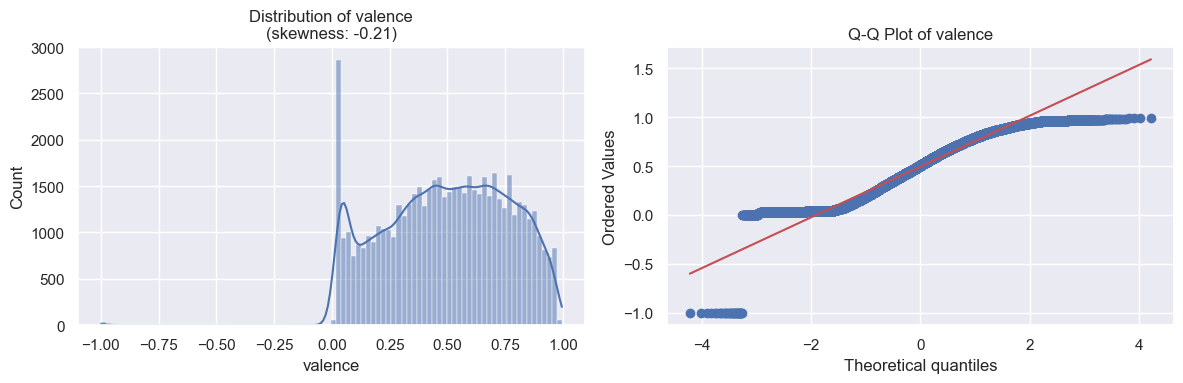


Testing normality for valence
Sample size: 56085
Range: -1.0 to 0.995
Mean: 0.50, Std: 0.26
Shapiro test statistic: 0.9661, p-value: 9.2211e-33

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.1899e-79

Trying sqrt transformation...
sqrt transformation p-value: 4.6885e-78

Trying box-cox transformation...
box-cox transformation p-value: 4.3384e-72

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.7498e-72
Best transformation: original (p-value: 9.2211e-33)

Analyzing popularity...

Original distribution:


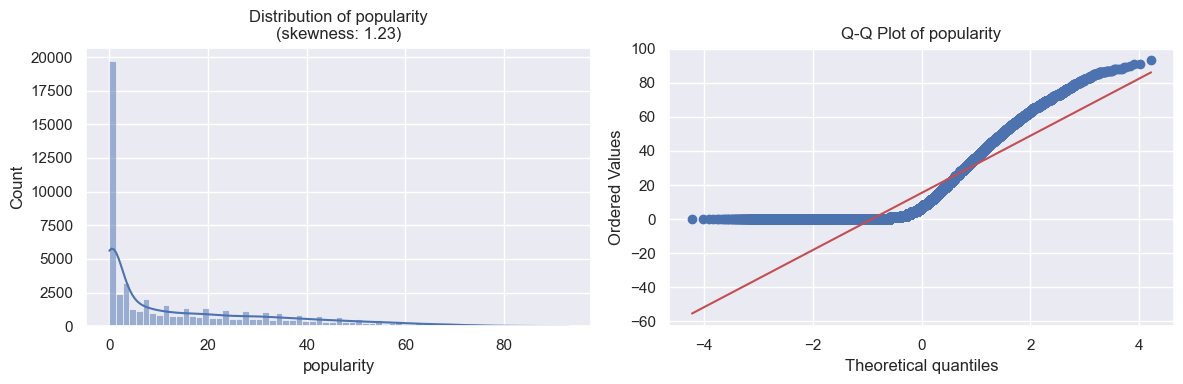


Testing normality for popularity
Sample size: 56085
Range: 0 to 93
Mean: 15.35, Std: 18.60
Shapiro test statistic: 0.8120, p-value: 1.9941e-60

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.0230e-103

Trying sqrt transformation...
sqrt transformation p-value: 1.3819e-103

Trying box-cox transformation...
box-cox transformation p-value: 5.5257e-104

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 5.5257e-104
Best transformation: original (p-value: 1.9941e-60)


In [10]:
results = []

for column in numeric_cols:
    print(f"\n{'='*50}")
    print(f"Analyzing {column}...")
    
    try:
        if df[column].nunique() <= 1:
            print(f"Skipping {column} - not enough unique values")
            continue
            
        if df[column].isnull().all():
            print(f"Skipping {column} - all values are null")
            continue
        
        print("\nOriginal distribution:")
        plot_distribution_and_qq(df, column)
        
        p_value = test_normality(df, column)
        
        if p_value < 0.05:
            print("\nData is not normally distributed. Trying transformations...")
            best_transform, transformed_data = suggest_transformation(df, column, p_value)
            print(f"Best transformation: {best_transform[0]} (p-value: {best_transform[1]:.4e})")
            
            if transformed_data is not None:
                temp_df = pd.DataFrame({f"{column}_transformed": transformed_data})
                print("\nTransformed distribution:")
                plot_distribution_and_qq(temp_df, f"{column}_transformed")
        else:
            print("\nData is normally distributed!")
        
        results.append({
            'column': column,
            'original_p_value': p_value,
            'needs_transformation': p_value < 0.05,
            'best_transformation': best_transform[0] if p_value < 0.05 else 'none',
            'transformed_p_value': best_transform[1] if p_value < 0.05 else p_value
        })
    except Exception as e:
        print(f"Error analyzing {column}: {str(e)}")

### Summary of Results

In [11]:
results_df = pd.DataFrame(results)
print("Summary of normality analysis:")
display(results_df)

Summary of normality analysis:


,column,original_p_value,needs_transformation,best_transformation,transformed_p_value
0,year,3.502553e-58,True,original,3.502553e-58
1,acousticness,8.472621e-50,True,original,8.472621e-50
2,danceability,3.486840e-38,True,original,3.486840e-38
3,duration_ms,1.129161e-73,True,original,1.129161e-73
4,energy,1.332133e-35,True,original,1.332133e-35
5,instrumentalness,8.021911e-79,True,original,8.021911e-79
6,key,9.954831e-43,True,original,9.954831e-43
7,liveness,4.377136e-67,True,original,4.377136e-67
8,loudness,9.011564e-96,True,yeo-johnson,1.884412e-63
9,mode,8.665517e-74,True,original,8.665517e-74
